In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from tab_benchmark.datasets import datasets_characteristics_path
from itertools import product
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# Save Results

## Load mlflow runs

In [4]:
db_port = 6001
db_name = 'tab_benchmark'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
# results_dir = Path('~/tab_benchmark/results')
# os.makedirs(results_dir, exist_ok=True)

In [5]:
experiment_names

['Default',
 'dnn_classification',
 'dnn_regression',
 'gbdt_classification',
 'gbdt_regression',
 'dnn_classification_others',
 'xgb_hpo_classification',
 'dnn_classification_transformer_max_1h']

In [6]:
experiment_names = [
    'dnn_regression', 'gbdt_regression',
]

In [7]:
params_columns = [
    'model_nickname',
    'model_name',
    'seed_model',
    'dataset_name',
    'task_id',
    'task_name',
    'task_fold',
    'n_gpus',
]

In [8]:
latest_metrics_columns = [
    'final_test_rmse',
    'final_test_r2_score',
    'elapsed_time',
]

In [9]:
tags_columns = [
    'was_evaluated',
    'EXCEPTION',
]

In [10]:
params_columns_query = [f"'{p}'" for p in params_columns]
params_columns_query = ', '.join(params_columns_query)

In [11]:
experiment_names_query = [f"'{e}'" for e in experiment_names]
experiment_names_query = ', '.join(experiment_names_query)

In [12]:
query = f"""
SELECT
	runs.run_uuid,
    runs.status,
    runs.start_time,
    runs.end_time,
	params."key",
	params.value
FROM
	runs
LEFT JOIN params ON
	params.run_uuid = runs.run_uuid
LEFT JOIN experiments ON
	experiments.experiment_id = runs.experiment_id
WHERE
	params."key" IN ({params_columns_query})
	AND experiments.name IN ({experiment_names_query})
"""
df_params = pd.read_sql(query, engine)
df_params = df_params.pivot(columns='key', index=['run_uuid', 'status', 'start_time', 'end_time'], values='value').reset_index()
df_params = df_params.set_index('run_uuid')

In [13]:
latest_metrics_columns_query = [f"'{m}'" for m in latest_metrics_columns]
latest_metrics_columns_query = ', '.join(latest_metrics_columns_query)

In [14]:
query = f"""
SELECT
	runs.run_uuid,
	latest_metrics."key",
	latest_metrics.value
FROM
	runs
LEFT JOIN latest_metrics ON
	latest_metrics.run_uuid = runs.run_uuid
LEFT JOIN experiments ON
	experiments.experiment_id = runs.experiment_id
WHERE
	latest_metrics."key" IN ({latest_metrics_columns_query})
	AND experiments.name IN ({experiment_names_query})
"""
df_latest_metrics = pd.read_sql(query, engine)
df_latest_metrics = df_latest_metrics.pivot(columns='key', index='run_uuid', values='value')

In [15]:
tags_columns_query = [f"'{tag}'" for tag in tags_columns]
tags_columns_query = ', '.join(tags_columns_query)

In [16]:
query = f"""
SELECT
	runs.run_uuid,
	tags."key",
	tags.value
FROM
	runs
LEFT JOIN tags ON
	tags.run_uuid = runs.run_uuid
LEFT JOIN experiments ON
	experiments.experiment_id = runs.experiment_id
WHERE
	tags."key" IN ({tags_columns_query})
	AND experiments.name IN ({experiment_names_query})
"""
df_tags = pd.read_sql(query, engine)
df_tags = df_tags.pivot(columns='key', index='run_uuid', values='value')

In [17]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [18]:
df_runs_raw

key,status,start_time,end_time,dataset_name,model_name,model_nickname,n_gpus,seed_model,task_fold,task_id,task_name,elapsed_time,final_test_r2_score,final_test_rmse,was_evaluated
run_uuid,,,,,,,,,,,,,,,
000f1c84cadd4c51a369c8b791b17932,FINISHED,1726306721738,1726312944821,shrutime,ResNet,TabBenchmarkResNet,0,0,4,362112,regression,6223.0,0.303900,0.815790,True
002fe8e430414d4a8167e085191d4105,FINISHED,1726274440275,1726278339536,fps_benchmark,ResNet,TabBenchmarkResNet,0,0,7,361268,regression,3899.0,0.999567,0.020860,True
00345fb1332248ebb8b54bc47bb3dd09,FINISHED,1726251916163,1726252098517,yacht_hydrodynamics,CatBoostRegressor,TabBenchmarkCatBoostRegressor,0,0,0,211860,regression,182.0,0.994087,0.058839,True
005ab8da6e5847b9b470ec3eba111377,FINISHED,1726285762272,1726285892391,breast-cancer-coimbra,ResNet,TabBenchmarkResNet,0,0,0,362097,regression,130.0,-0.263662,1.072607,True
005e756c3a554462bb2c5611e69e4468,FINISHED,1726246907238,1726246908017,QSAR_fish_toxicity,XGBRegressor,TabBenchmarkXGBRegressor,0,0,6,361621,regression,0.0,0.549344,0.639353,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffdebb4c3f1540eb9779208f2126be1c,FINISHED,1726717382556,1726717467960,slump,Transformer,TabBenchmarkTransformer,0,0,3,362106,regression,85.0,0.901107,0.315810,True
ffe9e49182264d65a0cbadbe19031fb9,FINISHED,1726734642739,1726734948390,optical_interconnection_network,Transformer,TabBenchmarkTransformer,0,0,2,211855,regression,305.0,0.950637,0.367373,True
fff357fc45fb4496b93ac3fc329e5939,FINISHED,1726249936958,1726249943259,computer_hardware,CatBoostRegressor,TabBenchmarkCatBoostRegressor,0,0,0,362087,regression,6.0,0.942978,0.159621,True


## Load specs file with all datasets being used

In [19]:
datasets_characteristics = pd.read_csv(datasets_characteristics_path)
datasets_regression = datasets_characteristics.loc[datasets_characteristics.task_name.isin(('regression', 'multi_regression'))]

## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [20]:
non_duplicate_columns = [
    'model_name',
    'seed_model',
    'task_id',
    'task_fold',    
]

In [21]:
df_runs = df_runs_raw.dropna(axis=0, how='all', subset=['final_test_rmse']).copy()
df_runs = df_runs.loc[(~df_runs.duplicated(non_duplicate_columns))]

In [22]:
# # some combinations of model-dataset will never run (memory needed is too high > 2 TiB)
# model_to_input = ['SkRandomForestModel', 'SkExtraTreeModel', 'SkGradientBoostingModel', 'SkExtraTreesModel', 'SkDecisionTreeModel', 'SkRidgeClassifierCVModel']
# dataset_name_to_input = ['albert']
# folds_to_input = [str(i) for i in range(5)]
# seed_dataset_to_input = ['0']
# seed_model_to_input = ['0']
# for model_name in model_to_input:
#     for dataset_name in dataset_name_to_input:
#         for fold in folds_to_input:
#             for seed_dataset in seed_dataset_to_input:
#                 for seed_model in seed_model_to_input:
#                     data_to_cat = {
#                         'model_name': model_name,
#                         'dataset_name': dataset_name,
#                         'fold': fold,
#                         'seed_model': seed_model,
#                         'seed_dataset': seed_dataset,
#                         'test_auc': 0,
#                         'test_logloss': 1e5,
#                         'duration': 1e5*3600
#                     }
#                     df_to_cat = pd.DataFrame(data_to_cat, index=[0])
#                     df_runs = pd.concat([df_runs, df_to_cat], axis=0)

# Missing

In [23]:
def get_missing_runs(df, columns_names, should_contain_values):
    df = df.copy()
    indexes = product(*should_contain_values)
    df_should_contain = pd.DataFrame(index=indexes)
    contain = [df[column_name] for column_name in columns_names]
    df['indexes'] = list(zip(*contain))
    df_missing = df.join(df_should_contain, 'indexes', how='right')
    df_missing = df_missing.loc[df_missing[columns_names[0]].isna()]
    df_missing = pd.DataFrame(df_missing.indexes.to_list(), columns=columns_names)
    return df_missing

In [24]:
df_runs['model_name'].unique().tolist()

['ResNet',
 'CatBoostRegressor',
 'XGBRegressor',
 'LGBMRegressor',
 'Transformer',
 'MLP']

In [25]:
non_duplicate_columns = [
    'model_name',
    'seed_model',
    'task_id',
    'task_fold',    
]

In [26]:
seed_model = ['0']
model_name = [
    'CatBoostRegressor',
    'XGBRegressor',
    'LGBMRegressor',
    'Transformer',
    'MLP',
    'ResNet',
]
fold = [str(i) for i in range(10)]
columns_names = non_duplicate_columns
dataset_tasks = [str(task) for task in datasets_regression.task_id.unique()]
should_contain_values = [model_name, seed_model, dataset_tasks, fold]
df_missing = get_missing_runs(df_runs, columns_names, should_contain_values)

In [27]:
df_missing

,model_name,seed_model,task_id,task_fold
0,Transformer,0,361293,0
1,Transformer,0,361293,1
2,Transformer,0,361293,2
3,Transformer,0,361293,3
4,Transformer,0,361293,4
...,...,...,...,...
294,Transformer,0,361279,3
295,Transformer,0,361279,4
296,Transformer,0,361279,5
297,Transformer,0,361279,8


In [60]:
print(*df_missing.task_id.unique())

361293 361292 361097 362086 361622 359942 362087 4883 361291 361268 361243 362089 2280 361266 52948 361294 4729 361260 4774 361101 361103 4850 361241 361259 362095 361250 362110 361254 361289 362117 362092 362112 362106 362107 362108 361623 361619 360966 361242 361287 362093 362094 4828 361252 361094 361253 361249 361076 211860 361091 361279


# Get common combinations

In [50]:
def get_common_combinations(df, column, combination_columns):
    df = df.copy()
    column_values = df[column].unique()
    values_combinations = {}
    for column_value in column_values:
        df_column_value = df.loc[df[column] == column_value]
        combinations = df_column_value[combination_columns].itertuples(index=False, name=None)
        values_combinations[column_value] = set(combinations)
    common_combinations = set.intersection(*values_combinations.values())
    return common_combinations

In [51]:
def get_df_with_combinations(df, combination_columns, combinations):
    df = df.copy()
    df['combination'] = list(df[combination_columns].itertuples(index=False, name=None))
    df = df.loc[df['combination'].isin(combinations)]
    df = df.drop(columns='combination')
    return df

In [52]:
model_name = [
    'CatBoostRegressor',
    'XGBRegressor',
    'LGBMRegressor',
    'Transformer',
    'MLP',
    'ResNet',
]
df = df_runs.copy()
df = df.loc[df['model_name'].isin(model_name)]
column = 'model_name'
combination_columns = ['seed_model', 'task_id', 'task_fold']
common_combinations = get_common_combinations(df, column, combination_columns)

In [53]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [57]:
df_runs.model_name.unique()

array(['ResNet', 'CatBoostRegressor', 'XGBRegressor', 'LGBMRegressor',
       'Transformer', 'MLP'], dtype=object)

# Display Results

In [40]:
def get_dfs_means_stds_both(df, column_model_name, column_task_id, column_dataset_name, column_metric):
    df = df.copy()
    columns = [column_model_name, column_task_id, column_dataset_name, column_metric]
    means = (
        df[columns].
        groupby(columns[:-1]).
        mean().
        reset_index(level=column_model_name).
        pivot(columns=column_model_name).
        droplevel(level=0,axis=1)
    )
    stds = (
        df[columns].
        groupby(columns[:-1]).
        std().
        reset_index(level=column_model_name).
        pivot(columns=column_model_name).
        droplevel(level=0,axis=1)
    )
    dfs = [means, stds]
    both = pd.concat([dfs[0], dfs[1]], keys=['mean', 'std'], axis=1)
    both.columns = both.columns.swaplevel(0, 1)
    both = both.sort_index(axis=1)
    return dfs[0], dfs[1], both

In [41]:
column_model_name = 'model_name'
column_task_id = 'task_id'
column_dataset_name = 'dataset_name'
column_metric = 'final_test_rmse'
logloss = get_dfs_means_stds_both(df_common, 
                               column_model_name, 
                               column_task_id,
                                  column_dataset_name,
                               column_metric)
column_metric = 'final_test_r2_score'
auc = get_dfs_means_stds_both(df_common, 
                                   column_model_name, 
                                   column_task_id,
                              column_dataset_name,
                                   column_metric)
# column_metric = 'duration'
# duration = get_dfs_means_stds_both(df_runs, 
#                                    column_model_name, 
#                                    column_task_id,
#                                    column_metric,
#                                    all_classification)

In [42]:
metrics = ['rmse', 'r2_score']
dfs = [logloss, auc]

## General

In [43]:
logloss[0]

,model_name,CatBoostRegressor,LGBMRegressor,Transformer,XGBRegressor
task_id,dataset_name,,,,
190418,dataset_sales,0.391467,0.413169,0.654809,0.415462
211855,optical_interconnection_network,0.143380,0.295604,0.195747,0.219515
211863,CSM,0.685010,0.703629,0.864035,0.581657
2280,kin8nm,0.347244,0.420972,0.363476,0.488750
2285,cleveland,0.712382,0.749208,0.782241,0.818041
...,...,...,...,...,...
4883,cpu_small,0.138509,0.144212,0.208663,0.154047
5012,chscase_foot,0.952739,1.006295,1.016094,1.029083
5040,EgyptianSkulls,0.914124,0.893373,0.928066,0.960506


In [44]:
idx = pd.IndexSlice
df = logloss[2].copy()
# df = df.drop('allstate_claim_predictions')
slice_ = idx[idx[:], idx[:,'mean']]
df.style.highlight_min(subset=slice_, axis=1)

In [45]:
idx = pd.IndexSlice
df = auc[2].copy()
# df = df.drop('allstate_claim_predictions')
slice_ = idx[idx[:], idx[:,'mean']]
df.style.highlight_max(subset=slice_, axis=1)

In [46]:
def friedman_nemenyi_test(df, model_column, block_column, metric_column, ascending_rank=False, alpha=0.95):
    df = df.copy()
    groups = [df.loc[df[model_column] == model, metric_column] for model in pd.unique(df[model_column])]
    res_friedman = friedmanchisquare(*groups)
    if res_friedman.pvalue < 1 - alpha:
        res_nemenyi = sp.posthoc_nemenyi_friedman(df, y_col=metric_column, block_col=block_column, 
                                                  group_col=model_column, melted=True)
        ranks = df.groupby([block_column])[metric_column].rank(ascending=ascending_rank)
        df['rank'] = ranks
        mean_rank = df.groupby(model_column)['rank'].mean()
        return res_friedman, res_nemenyi, mean_rank
    else:
        print(f'pvalue of {res_friedman.pvalue} is greater than alpha of {alpha}')
        return res_friedman, None, None

/home/bbelucci/miniconda3/envs/tab_benchmark/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


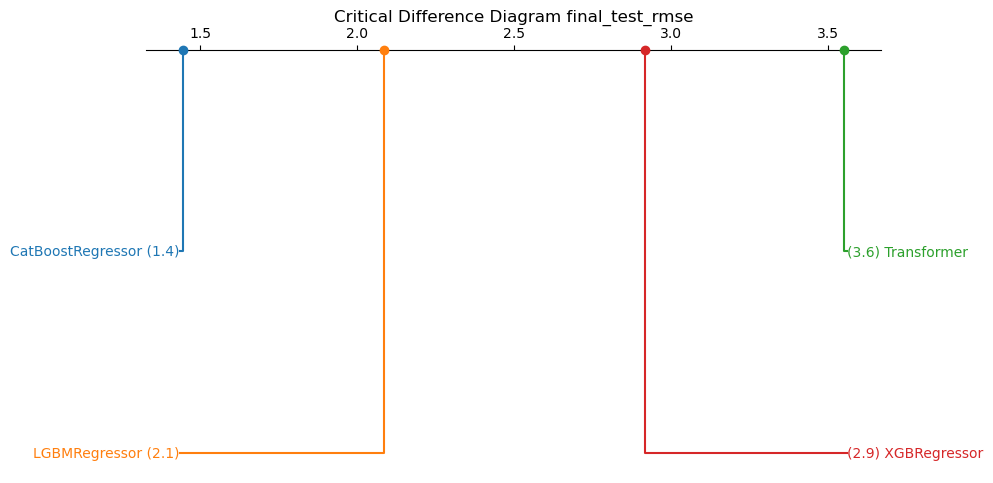

In [47]:
df = df_common.copy()
df['task_id_task_fold_seed_model'] = df['task_id'] + df['task_fold'] + df['seed_model']
metric = 'final_test_rmse'
ascending_rank = True
model_column = 'model_name'
block_column = 'task_id_task_fold_seed_model'
alpha = 0.95
res_friedman, res_nemenyi, mean_rank = friedman_nemenyi_test(df, model_column, block_column, 
                                                             metric, ascending_rank, alpha)
if res_nemenyi is not None and mean_rank is not None:
    plt.subplots(figsize=(10, 5))
    plt.title(f'Critical Difference Diagram {metric}')
    sp.critical_difference_diagram(mean_rank, res_nemenyi)
    plt.tight_layout()

/home/bbelucci/miniconda3/envs/tab_benchmark/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


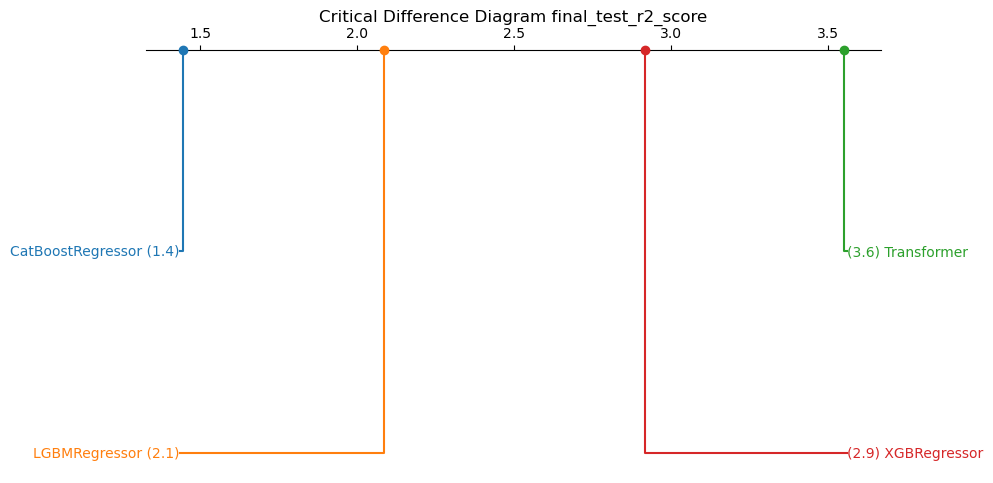

In [48]:
df = df_common.copy()
df['task_id_task_fold_seed_model'] = df['task_id'] + df['task_fold'] + df['seed_model']
metric = 'final_test_r2_score'
ascending_rank = False
model_column = 'model_name'
block_column = 'task_id_task_fold_seed_model'
alpha = 0.95
res_friedman, res_nemenyi, mean_rank = friedman_nemenyi_test(df, model_column, block_column, 
                                                             metric, ascending_rank, alpha)
if res_nemenyi is not None and mean_rank is not None:
    plt.subplots(figsize=(10, 5))
    plt.title(f'Critical Difference Diagram {metric}')
    sp.critical_difference_diagram(mean_rank, res_nemenyi)
    plt.tight_layout()

# Debug and explore

In [45]:
df_runs_raw[columns_names].duplicated().any()

False

In [36]:
df_to_delete = df_runs_raw.loc[df_runs_raw.test_logloss.isna()]

In [37]:
df_to_delete

key,status,start_time,end_time,dataset_name,model_name,model_nickname,seed_model,task_fold,task_id,task_name,test_auc,test_logloss,duration
run_uuid,,,,,,,,,,,,,
03cab7b441e34b40bd8ad8dc60fcd836,FINISHED,1726540996777,1726578901049,insurance_company,Transformer,TabBenchmarkTransformer,0,7,362081,binary_classification,NaN,NaN,10.528964
049febc2449c46c3afdd56d2afcaff5c,FINISHED,1726551253408,1726578901052,GesturePhaseSegmentationProcessed,Transformer,TabBenchmarkTransformer,0,4,14969,classification,NaN,NaN,7.679901
04abe372bcd84f2eadaea736307038f8,FINISHED,1726579962480,1726586658278,credit,Transformer,TabBenchmarkTransformer,0,6,361055,binary_classification,NaN,NaN,1.859944
05539e85c0604675b3f93096e8bc1feb,FINISHED,1726270121868,1726270157619,kc1,Transformer,TabBenchmarkTransformer,0,7,3917,binary_classification,NaN,NaN,0.009931
0e5ef3a920bf49869074fe5950bff043,FINISHED,1726579689874,1726586658276,artificial-characters,Transformer,TabBenchmarkTransformer,0,4,14964,classification,NaN,NaN,1.935667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
f1f2c35f12104ead8b8f7e6e320c92d4,FINISHED,1726458758738,1726458823282,magic,Transformer,TabBenchmarkTransformer,0,4,146206,binary_classification,NaN,NaN,0.017929
f26f36657d21499280e65e2581921373,FINISHED,1726573970041,1726578901053,pendigits,Transformer,TabBenchmarkTransformer,0,2,32,classification,NaN,NaN,1.369726
f2def598dec344d5a4e82e1a5510e4bc,FINISHED,1726583892918,1726586658286,Pulsar-Dataset-HTRU2,Transformer,TabBenchmarkTransformer,0,5,362099,binary_classification,NaN,NaN,0.768158


In [38]:
run_uuid_query = [f"'{run_id}'" for run_id in df_to_delete.index]
run_uuid_query = ', '.join(run_uuid_query)

In [39]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    